#### This code implements the galaxy cluster membership method proposed by George at al. 2011 (https://ui.adsabs.harvard.edu/abs/2011ApJ...742..125G/abstract), with some modifications

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set_style("ticks")

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.stats import sigma_clip

import scipy.integrate as integrate
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [2]:
cm1 = plt.cm.get_cmap('jet')
cm2 = plt.cm.get_cmap('rainbow')

fontsize = 40
labelsize = 30

color_bl = '#648FFF' #blue
color_id = '#785EF0' #indigo
color_mg = '#DC267F' #magenta
color_or = '#FE6100' #orange

/tmp/ipykernel_21644/2864973888.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('jet')
/tmp/ipykernel_21644/2864973888.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm2 = plt.cm.get_cmap('rainbow')


In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=71, Om0=0.27, Tcmb0=2.725)

### Define some functions that will be important throughout the code

In [15]:
def clustercentric_distance(ra, dec, ra0, dec0):
    '''
    Calculate the clustercentric distance of objects given their RA and DEC
    
    
    '''
    c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
    
    
    sep = []
    for (i,j) in zip(ra,dec):
        c = SkyCoord(i*u.degree, j*u.degree)
        sep.append(c0.separation(c).degree) 
    sep = np.asarray(sep)
    return sep

[ 1.76886212e-04 -8.07438409e-03  1.23970821e-01 -6.33901493e-01]


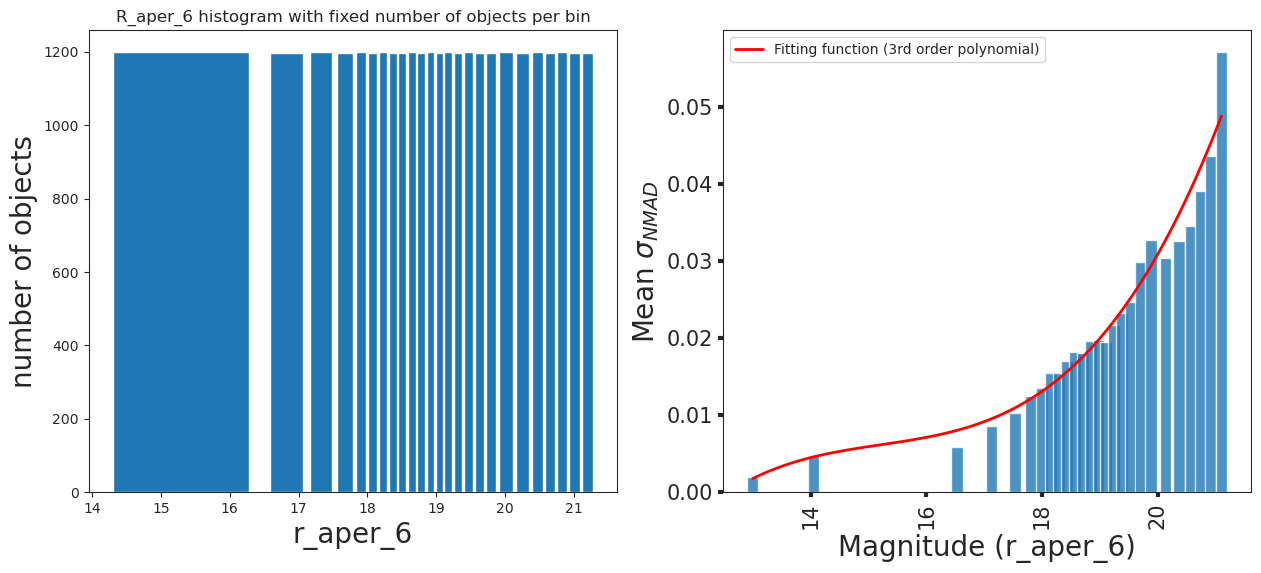

In [5]:
#Estimate sigma_nmad
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))


training_set = pd.read_csv("../CHANCES-target-selection/Results_DF.csv", usecols=['r_aper_6', 'zml', 'z'])

rmag_train = training_set["r_aper_6"]
zml_train = training_set["zml"]
z_train = training_set["z"]


fontsize=20
labelsize=15
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121)

n, bins, patches = ax1.hist(rmag_train, histedges_equalN(rmag_train, 25), histtype='bar', rwidth=0.8)
ax1.set_xlabel("r_aper_6", fontsize=fontsize)
ax1.set_ylabel("number of objects", fontsize=fontsize)
ax1.set_title("R_aper_6 histogram with fixed number of objects per bin", fontsize=fontsize*0.6)


mag = np.array(bins)
sigma_nmad = []
mag_bins = []

for i in range(1, len(mag), 1):
    mask_i = (rmag_train > mag[i-1]) & (rmag_train < mag[i])
    delta_z_i = zml_train[mask_i] - z_train[mask_i]
    sigma_nmad.append(np.abs(1.48 * np.median(abs(delta_z_i - np.median(delta_z_i)) / (1 + z_train[mask_i]))))
    mag_bins.append("{:.3f} <= r_mag <= {:.3f}".format(mag[i-1], mag[i]))

    
def func1(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

sigma_nmad_new = np.concatenate((np.array([2e-3]), sigma_nmad))
mag_new = np.concatenate((np.array([13.00]), mag))

xdata = mag_new[:-1]
ydata = sigma_nmad_new

popt1, pcov1 = curve_fit(func1, xdata, ydata)
print(popt1)

ax2 = fig.add_subplot(122)

xnew = np.linspace(xdata[0], xdata[-1], 100)
# ax.scatter(xdata, ydata)
ax2.bar(mag_new[:-1], sigma_nmad_new, alpha=0.8, width=0.2)
ax2.plot(xnew, func1(xnew, *popt1), linewidth=2.0, color='red', label="Fitting function (3rd order polynomial)")
ax2.set_xlabel("Magnitude (r_aper_6)", fontsize=fontsize)
ax2.set_ylabel(r"Mean $\sigma_{NMAD}$", fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, rotation=90)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3)
ax2.legend()
    

def sigma_nmad(r):
    if (r > mag_new[:-1][2]): sigma_nmad = func1(r, *popt1)
    elif (r <= mag_new[:-1][2]): sigma_nmad = func1(mag_new[:-1][2], *popt1)
    return sigma_nmad

In [6]:
def calc_PDF_series(weights, means, stds, x_range=None, optimize_zml=False):
    '''
    Returns a list of PDFs calculated as a combination of Gaussian functions

    Keyword arguments:
    x            -- Photometric redshift range for which the PDF should be calculated
    weights      -- Weight of the Gaussian components
    means        -- means of the Gaussian components
    stds         -- Standard deviation of the Gaussian components
    optimize_zml -- If the single-point estimate of photometric redshift should be optimized (if True, it will be
                    determined on a finer grid of points)
    '''
    
    if x_range is None:
        x = np.arange(-0.005, 1+0.001, 0.001) 
    else:
        x = x_range
                      
    # Convert columns from string to lists
    if type(weights) != np.ndarray:
        weights = np.array(weights)
        means   = np.array(means)
        stds    = np.array(stds)

    # Calculating PDFs and optimizing photo-zs (optional)
    PDFs           = []
    optimized_zmls = np.empty(len(means))
    
    if np.ndim(weights) == 2: # weights, means, and stds are 2D arrays 
        for i in range(len(weights)):
            PDF = np.sum(weights[i]*(1/(stds[i]*np.sqrt(2*np.pi))) * np.exp((-1/2) * ((x[:,None]-means[i])**2)/(stds[i])**2), axis=1)
            PDF = PDF/np.trapz(PDF, x)
            PDFs.append(PDF)
        zmls = x[np.argmax(PDFs, axis=1)]
        
    if np.ndim(weights) == 1:
        PDF  = np.sum(weights*(1/(stds*np.sqrt(2*np.pi))) * np.exp((-1/2) * ((x[:,None]-means)**2)/(stds)**2), axis=1)
        PDFs = PDF/np.trapz(PDF, x)
        zmls = x[np.argmax(PDFs)]

    if optimize_zml == True:
        for i in range(len(weights)):
            # First run
            optimized_x   = np.linspace(zmls[i]-0.002, zmls[i]+0.002, 500, endpoint=True)
            optimized_PDF = np.sum(weights[i]*(1/(stds[i]*np.sqrt(2*np.pi))) * np.exp((-1/2) * ((optimized_x[:,None]-means[i])**2)/(stds[i])**2), axis=1)
            optimized_zml = optimized_x[np.argmax(optimized_PDF)]

            # Second run
            optimized_x   = np.linspace(optimized_zml-0.001, optimized_zml+0.001, 300, endpoint=True)
            optimized_PDF = np.sum(weights[i]*(1/(stds[i]*np.sqrt(2*np.pi))) * np.exp((-1/2) * ((optimized_x[:,None]-means[i])**2)/(stds[i])**2), axis=1)
            optimized_zmls[i] = optimized_x[np.argmax(optimized_PDF)]

        zmls = optimized_zmls
                
    return PDFs, zmls, x

### Load data for Hydra

Here I am applying the method to the same Hydra catalogue I used when making the target selection for CHANCES. Instead of applying the previous photo-z selection method we had (the 3rd degree polynomial function) I apply the new membership method.

In [9]:
table = pd.read_csv("../CHANCES-target-selection/tables-photometric/Hydra-InSPLUS-AndLegacy-CHANCES.csv", 
                    usecols=["RA_J2000", "Dec_J2000", "pdf_means", "pdf_weights", "pdf_stds", "r_petro", "zml"])

In [10]:
ra_hydra = np.array(table["RA_J2000"])
dec_hydra = np.array(table["Dec_J2000"])
means_hydra = np.array(table["pdf_means"])
weights_hydra = np.array(table["pdf_weights"])
stds_hydra = np.array(table["pdf_stds"])
rpetro_hydra = np.array(table["r_petro"])
zml_hydra = np.array(table["zml"])

In [11]:
#Defining the center of Hydra (in degress)
ra0 = 159.17
dec0 = -27.524

#Defining the radius of 1R200 around the center (in degrees)
#R200 = 1.4Mpc + scale of 0.247 Kpc/" ==> radius = 1.5744º
radius = 1.5744

#Redshift of Hydra
zagl_hydra = 0.012

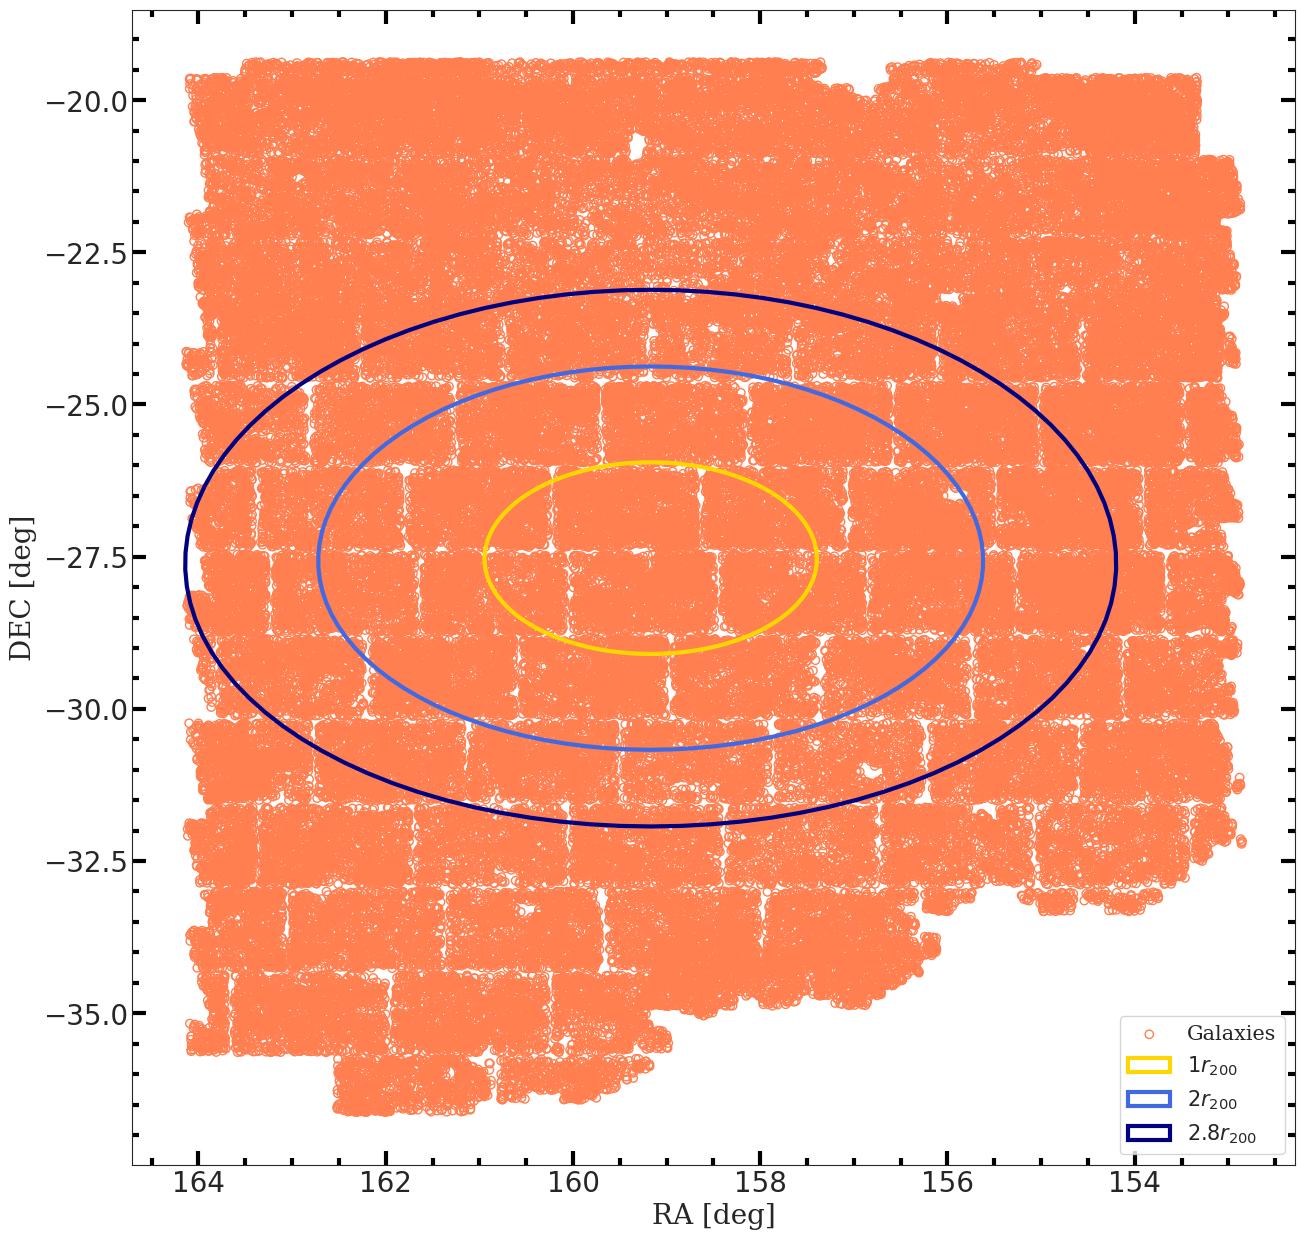

In [12]:
fig = plt.figure(figsize=(15, 15), dpi=100)
ax1 = fig.add_subplot(111)
ax1.scatter(ra_hydra, dec_hydra, marker='o', color='coral', facecolor='none', label="Galaxies")
ax1.set_xlabel('RA [deg]',fontsize=fontsize, family='serif')
ax1.set_ylabel('DEC [deg]',fontsize=fontsize, family='serif')

c0 = SkyCoord(ra=ra0, dec=dec0, frame='icrs', unit='deg')
b1 = SphericalCircle(c0, radius*u.deg, resolution=100, vertex_unit='deg', lw=3, label=r'$1 r_{200}$', edgecolor="gold", facecolor="None")
b2 = SphericalCircle(c0, 2*radius*u.deg, resolution=100, vertex_unit='deg', lw=3, label=r'$2 r_{200}$', edgecolor="royalblue", facecolor="None")
b3 = SphericalCircle(c0, 2.8*radius*u.deg, resolution=100, vertex_unit='deg', lw=3, label=r'$2.8 r_{200}$', edgecolor="navy", facecolor="None")
ax1.add_patch(b1)
ax1.add_patch(b2)
ax1.add_patch(b3)

ax1.legend(fontsize=labelsize, prop={'size':labelsize,'family':'serif'})

ax1.invert_xaxis()

tick_color = 'black'
ax1.xaxis.set_tick_params(which='both',labelsize=20,direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)
ax1.yaxis.set_tick_params(which='both',labelsize=20,direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)

plt.tick_params(which='both', width=3, length=5)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=5)
ax1.minorticks_on()

# plt.savefig("../Figures/Hydra-Centaurus/galaxy-membership/Hydra_Ra_DEC_circles.pdf", dpi='figure', format='pdf')

#### We have to compute the approximate density of field galaxies in the region of the Cluster, $n_F$, which is an important quantity to compute the priors  $P(g \in F)$ and $P(g \in G) = 1 - P(g \in F)$

First, we have to exclude a volume around the cluster, which means excluding a certain radius (Rmax) and a certain range of redshifts $z_G \pm \sigma_z$. Then, using the remaining galaxies, we compute a background density of field galaxies, $n_F$, which we can use afterwards to compute $N_F = \int n_F dz d \Omega = n_F \pi \Delta r^2 \Delta z$ in the region we want. 

In [13]:
#Calculate sigma_nmad for each galaxy, as a function of magnitude
sigma_z = np.array([sigma_nmad(r) for r in rpetro_hydra])

In [16]:
#Calculate separation of the galaxies to the center of the Cluster
sep_hydra = clustercentric_distance(ra_hydra, dec_hydra, ra0, dec0)

In [17]:
#Create a mask to select candidate field galaxies
Rlim = 2.8*radius
Ragl = 2.0*radius
f = 1.5

mask_field = (sep_hydra > Ragl) & (sep_hydra < Rlim) & ((zml_hydra < (zagl_hydra - f*sigma_z)) 
                                                              | (zml_hydra > (zagl_hydra + f*sigma_z)))

In [18]:
#Calculating the field galaxy number density
zlim = zml_hydra[mask_field].max()
zmin = zml_hydra[mask_field].min()

volume_field = np.pi * (zlim - zmin) * (Rlim**2 - Ragl**2)
n_F = np.sum(mask_field) / volume_field

In [19]:
N_F = n_F * np.pi * Ragl**2 * zmin
print("Number of field galaxies in the region of the cluster by computing first the density n_F: {:.2f}".format(N_F))

Number of field galaxies in the region of the cluster by computing first the density n_F: 1910.48


#### Now that we have an "independent" way of calculating $N_F$, we can use it and calculate the prior $P(g \in F) = \frac{N_F}{N_{tot}}$ and $P(g \in G) = 1 - P(g \in F)$

In [20]:
mask_tot = (sep_hydra < Ragl) & (zml_hydra < (zagl_hydra + 5*sigma_z))
N_tot = np.sum(mask_tot)
print("Total number of galaxies in the region of the cluster: {:.2f}".format(N_tot))

P_ginF = N_F / N_tot
print("Prior P(g in F): {:.2f}".format(P_ginF))

P_ginG = 1 - P_ginF
print("Prior P(g in G): {:.2f}".format(P_ginG))

Total number of galaxies in the region of the cluster: 6754.00
Prior P(g in F): 0.28
Prior P(g in G): 0.72


#### Next, we have to calculate $\mathcal{P}(P(z) | G)$ and $\mathcal{P}(P(z) | F)$:

$$
\mathcal{P}(P(z) | G) = \int_{z_G - 3 \sigma_z}^{z_G + 3 \sigma_z} \mathcal{P}(z) \mathcal{N}(z_G, \sigma_z) dz
$$

$$
\mathcal{P}(P(z) | F) = \int_{z_G - 3 \sigma_z}^{z_G + 3 \sigma_z} \frac{\mathcal{P}(z)}{\mathcal{w}(\sigma_z)}
$$

In [21]:
def P_pz(i, zagl, means, weights, stds, rmag):

    sigma = sigma_nmad(rmag[i])
    
    means = np.array([float(_) for _ in means[i].split(',')])
    weights = np.array([float(_) for _ in weights[i].split(',')])
    stds = np.array([float(_) for _ in stds[i].split(',')])

    pdfs, zmls, x = calc_PDF_series(weights, means, stds) 
    
    pdfs_interp = interp1d(x, pdfs)
    a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]

    pdf_func = lambda x: a * pdfs_interp(x)
        
    
    def gaussian(x, zagl, sigma):
        y = lambda x, zagl, sigma: (1 / sigma * np.sqrt(2* np.pi)) * np.exp(-(x - zagl)**2 / (2*sigma**2)) 
        a = 1 / integrate.quad(y, 0.0, np.inf, args=(zagl, sigma))[0]
        return a * y(x, zagl, sigma)
    
     
    if zagl - 3*sigma <= 0:
        P_pz_G = integrate.quad(lambda x, sigma, zagl: pdf_func(x) * gaussian(x, zagl, sigma), 0.0, zagl + 3*sigma, args=(sigma, zagl))[0] 
        P_pz_F = integrate.quad(lambda x, sigma: pdf_func(x) / (6*sigma), 0.0, zagl + 3*sigma, args=(sigma))[0]
        
    if zagl - 3*sigma > 0:
        P_pz_G = integrate.quad(lambda x, sigma, zagl: pdf_func(x) * gaussian(x, zagl, sigma), zagl - 3*sigma, zagl + 3*sigma, args=(sigma, zagl))[0] 
        P_pz_F = integrate.quad(lambda x, sigma: pdf_func(x) / (6*sigma), zagl - 3*sigma, zagl + 3*sigma, args=(sigma))[0]
        
    return P_pz_G, P_pz_F

In [ ]:
Pmem_hydra = np.zeros(len(zml_hydra))
for i in range(len(zml_hydra)):  
    P_pz_G_i, P_pz_F_i = P_pz(i, zagl_hydra, means_hydra, weights_hydra, stds_hydra, rpetro_hydra)
    Pmem_hydra[i] = (P_pz_G_i * P_ginG) / (P_pz_G_i * P_ginG + P_pz_F_i * P_ginF)

In [ ]:
crit = 0.84
ms = 3

fig = plt.figure(figsize=(30, 15))
ax1 = fig.add_subplot(121)
# ax1.scatter(ra_hydra[Pmem < crit], dec_hydra[Pmem < crit], marker='o', color='coral', facecolor='none', s=2, label='Field')
ax1.scatter(ra_hydra[Pmem > crit], dec_hydra[Pmem > crit], marker='o', color='darkred', s=10, label='Cluster')
ax1.set_xlabel('x',fontsize=fontsize)
ax1.set_ylabel('y',fontsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.set_title("Cluster/Field separation using our membership method (Pmem > {:.2f})".format(crit), fontsize=labelsize)

ax2 = fig.add_subplot(122)
sc2 = ax2.scatter(ra_hydra, dec_hydra, marker='o', c=Pmem, cmap=cm2, s=ms, facecolor='none')
ax2.set_xlabel('x',fontsize=fontsize)
ax2.set_ylabel('y',fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.legend(fontsize=labelsize)
ax2.set_title("Membership probability", fontsize=labelsize)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(sc2, cax=cax2, orientation='vertical')

ax1.legend(fontsize=labelsize)

### We can do it for a catalogue crossmatched with spectroscopic data and compare the result with what we get from applying sigma clipping galaxy membership over the spectroscopic data. With this, we can also see what is the better probability cut to apply to select cluster members

In [22]:
table_speczs = pd.read_csv("../CHANCES-target-selection/tables-photometric/Hydra-InSPLUS-AndLegacy-CHANCES-specz_crossmatch.csv", 
                                     usecols=["OBJECT_ID", "RA_J2000", "Dec_J2000", "pdf_means", "pdf_weights", "pdf_stds", "r_petro", "zml", "z"])

In [23]:
objid_specz = np.array(table_speczs["OBJECT_ID"])
ra_specz = np.array(table_speczs["RA_J2000"])
dec_specz = np.array(table_speczs["Dec_J2000"])
means_specz = np.array(table_speczs["pdf_means"])
weights_specz = np.array(table_speczs["pdf_weights"])
stds_specz = np.array(table_speczs["pdf_stds"])
rpetro_specz = np.array(table_speczs["r_petro"])
zml_specz = np.array(table_speczs["zml"])
z_specz = np.array(table_speczs["z"])

In [24]:
#Define a range of redshifts for the cluster
zlower = 0
zupper = 0.03

In [25]:
def sigma_clipping(z_spec, ids, zlower, zupper, sigma):
    '''
    Perform a cluster spectroscopic membership using sigma clipping
    '''
    # It is necessary to restrict a little the sample.  We have to look at this cluster by cluster
    cluster_max_cut = (z_spec > zlower) & (z_spec < zupper)

    cluster_sig = sigma_clip(z_spec[cluster_max_cut], sigma=sigma, cenfunc='median', stdfunc='mad_std') 

    # Objects selected after applying the 3sigmaclipping cut
    specz_members = z_spec[cluster_max_cut][~cluster_sig.mask]
    id_members = ids[cluster_max_cut][~cluster_sig.mask]
    
    return specz_members, id_members

In [26]:
z_members, id_members = sigma_clipping(z_specz, objid_specz, zlower, zupper, 3)
mask_members = np.isin(objid_specz, id_members)

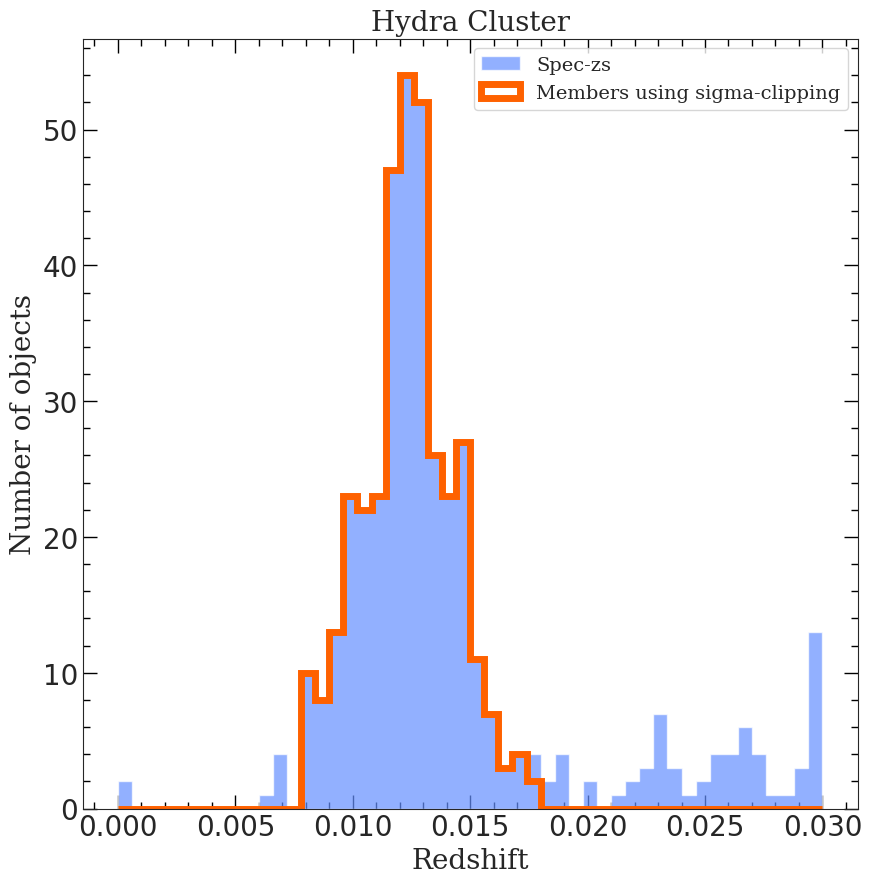

In [27]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111)

ax.hist(z_specz, alpha=0.7, label='Spec-zs', bins=50, range=(zlower, zupper), histtype='stepfilled', color=color_bl)
ax.hist(z_members, alpha=1.0, label='Members using sigma-clipping', bins=50, range=(zlower, zupper), histtype='step', lw=5, color=color_or)
ax.set_title('Hydra Cluster', fontsize=fontsize, family = 'serif')
ax.set_xlabel("Redshift", fontsize=fontsize, family = 'serif')
ax.set_ylabel("Number of objects", fontsize=fontsize, family = 'serif')

tick_color = 'black'
ax.xaxis.set_tick_params(which='both', labelsize=20, direction='in', color=tick_color, bottom=True, top=True, left=True, right=True)
ax.yaxis.set_tick_params(which='both', labelsize=20, direction='in', color=tick_color, bottom=True, top=True, left=True, right=True)

plt.tick_params(which='both', width=1.0)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=5)
ax.minorticks_on()

lg=plt.legend(loc=0, prop={'size':fontsize*0.7,'family':'serif'})
lg.draw_frame(True)

In [28]:
Pmem_specz = np.zeros(len(zml_specz))
for i in range(len(zml_specz)):  
    P_pz_G_i, P_pz_F_i = P_pz(i, zagl_hydra, means_specz, weights_specz, stds_specz, rpetro_specz)
    Pmem_specz[i] = (P_pz_G_i * P_ginG) / (P_pz_G_i * P_ginG + P_pz_F_i * P_ginF)

/tmp/ipykernel_21644/3874383896.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  a = 1 / integrate.quad(pdfs_interp, 0.0, 1.0)[0]
/tmp/ipykernel_21644/3874383896.py:24: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a 

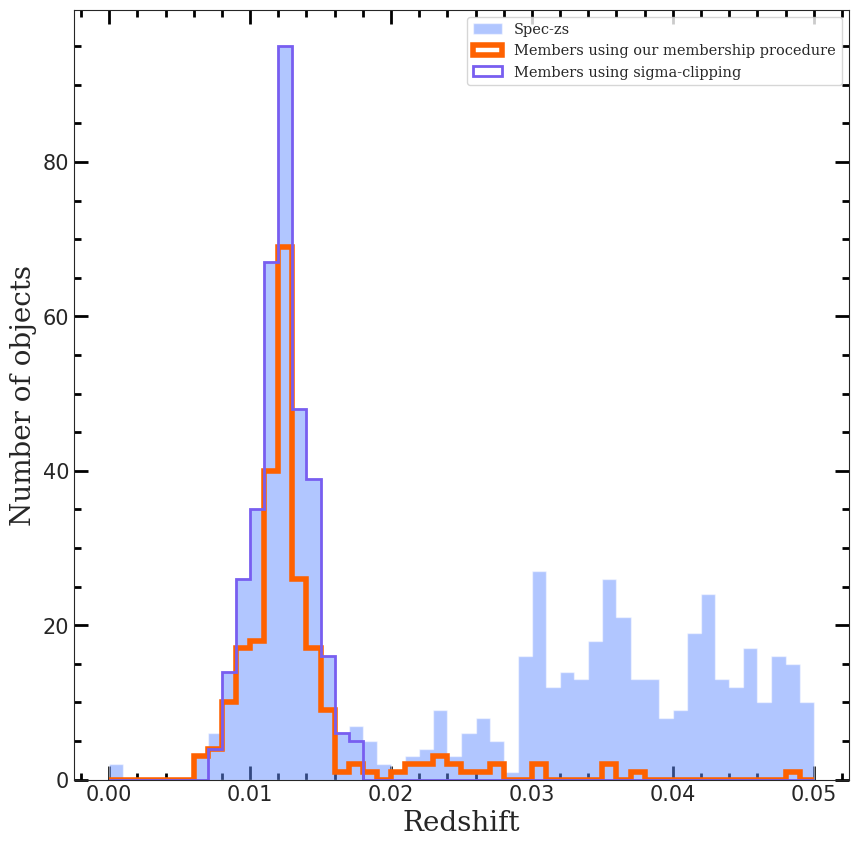

In [29]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(111)

ax.hist(z_specz, alpha=0.5, label='Spec-zs', bins=50, range=(0, 0.05), histtype='stepfilled', color=color_bl)
ax.hist(z_specz[Pmem_specz > 0.825], alpha=1.0, label='Members using our membership procedure', bins=50, range=(0, 0.05), histtype='step', lw=4, color=color_or)
ax.hist(z_members, alpha=1.0, label='Members using sigma-clipping', bins=50, range=(0, 0.05), histtype='step', lw=2, color=color_id)
# ax.set_title('Hydra Cluster', fontsize=fontsize, family = 'serif')
ax.set_xlabel("Redshift", fontsize=fontsize, family = 'serif')
ax.set_ylabel("Number of objects", fontsize=fontsize, family = 'serif')

tick_color = 'black'
ax.xaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)
ax.yaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)

plt.tick_params(which='both', width=2.0)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=5)
ax.minorticks_on()

lg=plt.legend(loc=0, prop={'size':labelsize*0.7,'family':'serif'})
lg.draw_frame(True)

# plt.savefig("../Figures/Hydra-Centaurus/galaxy-membership/specz_distribution_sigma_clipping_membership.pdf", dpi='figure', format='pdf')

In [30]:
completeness = []
purity = []
d = 0.005
crit = np.arange(0.5, 0.85, d)

for c in crit:
    completeness.append(np.sum((Pmem_specz > c) & mask_members) / np.sum(mask_members))
    purity.append(np.sum(mask_members & (Pmem_specz > c)) / np.sum((Pmem_specz > c)))

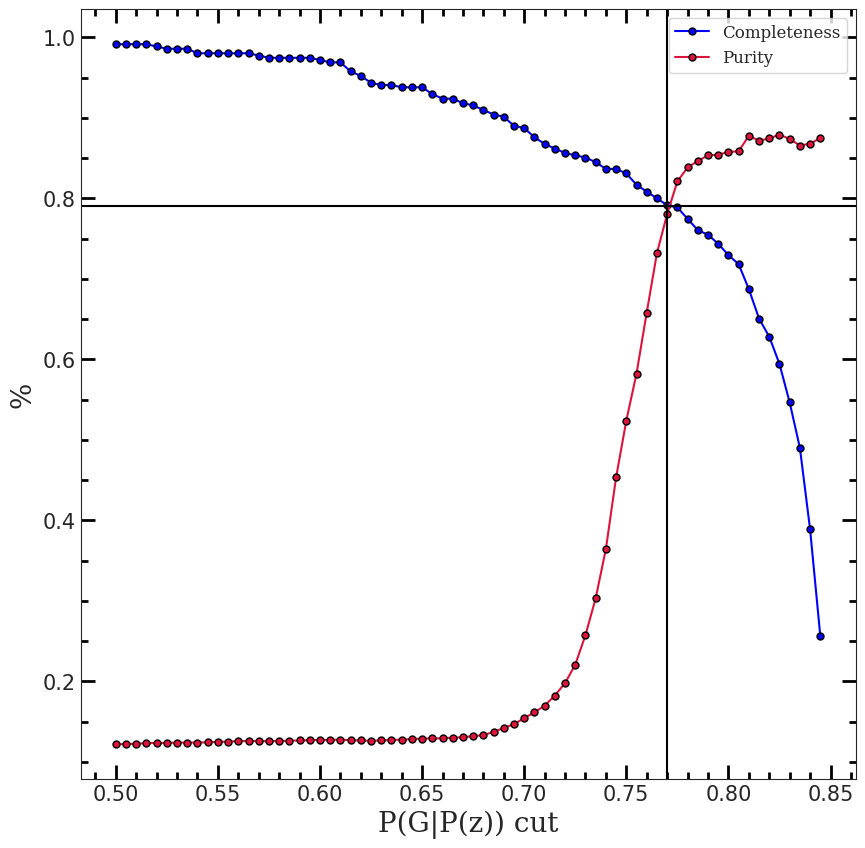

In [31]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax1 = fig.add_subplot(111)

ms = 5
ax1.plot(crit, completeness, marker='o', color="blue", markerfacecolor="blue", label="Completeness", markersize=ms, markeredgecolor="black")
ax1.plot(crit, purity, marker='o', color="crimson", markerfacecolor="crimson", label="Purity", markersize=ms, markeredgecolor="black")

# ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=7)
# ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=7)

ax1.set_ylabel("%", fontsize=fontsize, family='serif')
ax1.set_xlabel("P(G|P(z)) cut", fontsize=fontsize, family='serif')
# ax1.set_title("Membership probability purity and completeness", fontsize=fontsize, family='serif')
ax1.legend(fontsize=13)

tick_color = 'black'
ax1.xaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)
ax1.yaxis.set_tick_params(which='both',labelsize=labelsize, direction='in',color=tick_color,bottom=True,top=True,left=True,right=True)

plt.tick_params(which='both', width=2.0)
plt.tick_params(which='major', length=10)
plt.tick_params(which='minor', length=5)
ax1.minorticks_on()

lg=plt.legend(loc=0, prop={'size':labelsize*0.8,'family':'serif'})
lg.draw_frame(True)

ax1.axvline(0.77, color="black")
ax1.axhline(0.79, color="black")
# plt.savefig("../Figures/Hydra-Centaurus/galaxy-membership/membership_probability_purity_completeness_hydra.pdf", dpi='figure', format='pdf')